In [3]:
import pickle
import numpy as np
import sys
sys.path.insert(0, '/nfs/mwa-09/r1/abrahamn/21cmIR/21cmIRxcor')
import cat_utils

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io.votable import parse
from astropy.table import Table

from scipy.optimize import curve_fit

In [5]:
#d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57639/whole_field/'
#d = '/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I/'
d = '/nfs/mwa-09/r1/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I/'

sefluxname = 'best'
#secat = pickle.load( open(d+'whole_field_secat_'+sefluxname+'.p', "rb" ) )
# secat = pickle.load( open(d+'whole_field_secat_best_magoffset=0.279.p', "rb" ) )
secat = pickle.load( open(d+'0298I_0302I_0306I_0318I_0322I_0326I_0338I_0342I_0346I_secat_best.p', "rb" ) )
g = secat.jy>1.e-10
secat = cat_utils.Catalog(secat.ra[g],secat.dec[g],secat.jy[g])

In [6]:
len(secat.jy)

50823

In [8]:
# apass cat
#apasscatdat = np.genfromtxt('/home/abrahamn/xcor_data/ir_catalogs/apass_6degcat.csv',skip_header=2,delimiter=',')
apasscatdat = np.genfromtxt('/nfs/mwa-09/r1/abrahamn/xcor_data/ir_catalogs/apass_6degcat.csv',skip_header=2,delimiter=',')
has_iprime_mag = np.logical_not(np.isnan(apasscatdat[:,23]))
apass_cat = cat_utils.Catalog(apasscatdat[has_iprime_mag,2],apasscatdat[has_iprime_mag,3],3631.*10.**(-apasscatdat[has_iprime_mag,23]/2.5))

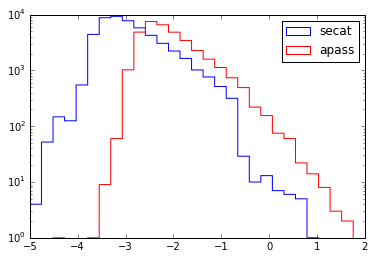

In [17]:
b = np.linspace(-5,2,30)
plt.hist(np.log10(secat.jy),b,histtype='step',color='blue',label='secat')
plt.hist(np.log10(apass_cat.jy),b,histtype='step',color='red',label='apass')
plt.gca().set_yscale('log')
plt.legend()

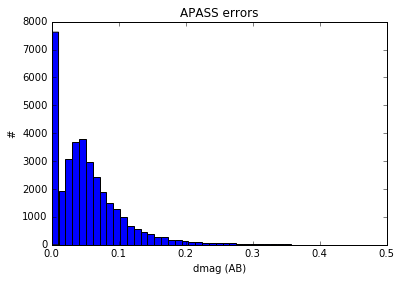

In [5]:
h = plt.hist(apasscatdat[has_iprime_mag,24],np.linspace(0,.5))
plt.xlabel('dmag (AB)')
plt.ylabel('#')
plt.title('APASS errors')

In [73]:
# # dophot cat
# dophot_cat = cat_utils.IRCatalog('/home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph')
# dophot_cat.ra = dophot_cat.ra_all
# dophot_cat.dec = dophot_cat.dec_all
# dophot_cat.jy = dophot_cat.jy_all

In [74]:
# plt.plot(dophot_cat.ra_all,dophot_cat.dec_all,'.')

In [75]:
# # to get early skymapper data, do a cone search through an australian proxy
# # http://skymapper.anu.edu.au.prx.teleport.to/edr_cone/query?RA=1&DEC=-29&SR=.35&VERB=2

# # need to edit the xml file and change datatypes "character(18)" and "character(3)" to "char"
# catdir = '/home/abrahamn/xcor_data/ir_catalogs/'
# skymappercatraw = parse(catdir + 'view-source_skymapper.anu.edu.au.prx.teleport.to_edr_cone_query_RA=1&DEC=-29&SR=.35&VERB=2.xml').get_first_table().array

In [76]:
# skymappercatraw.dtype

In [77]:
# # http://skymapper.anu.edu.au/table-browser/
# ra = skymappercatraw['raj2000']
# dec = skymappercatraw['dej2000']
# flags = skymappercatraw['flags']
# ab_mag_psf = skymappercatraw['i_psf'] # mag measured by psf fitting
# d_ab_mag_psf = skymappercatraw['e_i_psf'] # mag measured by psf fitting
# ab_mag_petro = skymappercatraw['i_petro'] # mag measured in an azimuthally averaged radius, see http://www.sdss.org/dr12/algorithms/magnitudes/#mag_petro

# jy_psf = 3631.*10.**(-ab_mag_psf/2.5)
# jy_petro = 3631.*10.**(-ab_mag_petro/2.5)

# skymapper_cat = cat_utils.Catalog(ra,dec,jy_psf)

In [78]:
# h = plt.hist(apasscatdat[has_iprime_mag,24],np.linspace(0,.5),histtype='step',label='apass errors',normed=True,color='red')
# h = plt.hist(d_ab_mag_psf,np.linspace(0,.5),histtype='step',label='skymapper errors',normed=True,color='blue')
# plt.xlabel('dmag (AB)')
# plt.ylabel('#')
# plt.legend()
# plt.title('mag errors')

In [79]:
# secat = secat.bound_with_cat(skymapper_cat)
# dophot_cat = dophot_cat.bound_with_cat(skymapper_cat)
# apass_cat = apass_cat.bound_with_cat(skymapper_cat)

In [80]:
# plt.figure(figsize=(20,15))
# plt.scatter(ra,dec,25000*skymapper_cat.jy,edgecolor='none',facecolor='red')

# plt.scatter(secat_bounded.ra,secat_bounded.dec,25000*secat_bounded.jy,facecolor='none')
# plt.scatter(dophot_cat_bounded.ra,dophot_cat_bounded.dec,25000*dophot_cat_bounded.jy,facecolor='none',edgecolor='blue')

# plt.scatter(apass_cat_bounded.ra,apass_cat_bounded.dec,25000*apass_cat_bounded.jy,facecolor='none',edgecolor='cyan')

In [81]:
# for each sextractor source, look for matching dophot and source extractor sources

# cats = [apass_cat,dophot_cat,skymapper_cat]
cats = [apass_cat]
catnames = ['APASS','ATLAS/dophot','skymapper']
indices_matching_srcs = np.zeros((len(cats),len(secat.jy)),dtype=int)-1 # -1 if no match
for cati in range(len(cats)):
    for i in range(len(secat.jy)):
        if i % 100 == 0: print('%f'%(1.*i/len(secat.jy)))
        asec_to_all_cat_sources = np.sqrt((secat.dec[i]-cats[cati].dec)**2+np.sin(secat.dec[i]*np.pi/180)**2*(secat.ra[i]-cats[cati].ra)**2)*3600.
        if np.min(asec_to_all_cat_sources) < 1:
            indices_matching_srcs[cati,i] = np.argmin(asec_to_all_cat_sources)

0.000000
0.001968
0.003935
0.005903
0.007870
0.009838
0.011806
0.013773
0.015741
0.017709
0.019676
0.021644
0.023611
0.025579
0.027547
0.029514
0.031482
0.033449
0.035417
0.037385
0.039352
0.041320
0.043287
0.045255
0.047223
0.049190
0.051158
0.053126
0.055093
0.057061
0.059028
0.060996
0.062964
0.064931
0.066899
0.068866
0.070834
0.072802
0.074769
0.076737
0.078705
0.080672
0.082640
0.084607
0.086575
0.088543
0.090510
0.092478
0.094445
0.096413
0.098381
0.100348
0.102316
0.104283
0.106251
0.108219
0.110186
0.112154
0.114122
0.116089
0.118057
0.120024
0.121992
0.123960
0.125927
0.127895
0.129862
0.131830
0.133798
0.135765
0.137733
0.139701
0.141668
0.143636
0.145603
0.147571
0.149539
0.151506
0.153474
0.155441
0.157409
0.159377
0.161344
0.163312
0.165279
0.167247
0.169215
0.171182
0.173150
0.175118
0.177085
0.179053
0.181020
0.182988
0.184956
0.186923
0.188891
0.190858
0.192826
0.194794
0.196761
0.198729
0.200697
0.202664
0.204632
0.206599
0.208567
0.210535
0.212502
0.214470
0.216437
0

In [82]:
def jy2mag(jy):
    return -2.5*np.log10(jy/3631.)

In [83]:
len(secat.jy)

50823

In [84]:
np.sum(indices_matching_srcs[0,:]>0)

9515

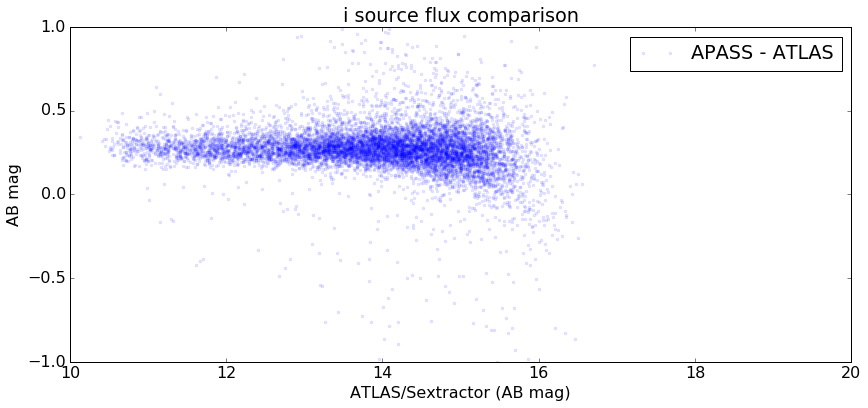

In [85]:
plt.figure(figsize=(14,6))

stys = ['b.','r.','c.']

for cati in range(len(cats)):
    plt.plot(jy2mag(secat.jy[indices_matching_srcs[cati,:]>0]),\
             jy2mag(cats[cati].jy[indices_matching_srcs[cati,indices_matching_srcs[cati,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[cati,:]>0]),stys[cati],\
             label=str(catnames[cati])+' - ATLAS',alpha=.1)

plt.xlim([10,20])
plt.ylabel('AB mag')
plt.legend()
plt.ylim([-1,1])
plt.xlabel('ATLAS/Sextractor (AB mag)')
plt.title('i source flux comparison')

#plt.savefig('skymapper_vs_dophot_vs_se_'+sefluxname+'.png',bbox_inches='tight')

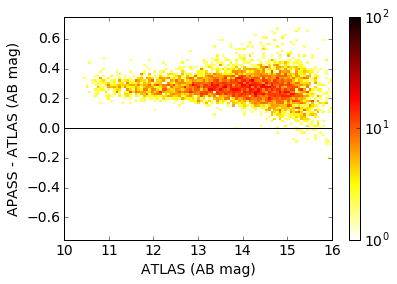

In [88]:
matplotlib.rcParams.update({'font.size': 14})
b = [np.linspace(10,16,100),np.linspace(-.75,.75,100)]
h = plt.hist2d(jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           jy2mag(cats[0].jy[indices_matching_srcs[0,indices_matching_srcs[0,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           bins=b,\
           norm=matplotlib.colors.LogNorm(),cmap='hot_r',vmin=1,vmax=100)
plt.colorbar()
plt.plot([10,16],[0,0],'k-')
plt.xlabel('ATLAS (AB mag)')
plt.ylabel('APASS - ATLAS (AB mag)')

In [89]:
magdiff = jy2mag(cats[0].jy[indices_matching_srcs[0,indices_matching_srcs[0,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[0,:]>0])
brightenough = jy2mag(secat.jy[indices_matching_srcs[0,:]>0])<13
counts,binedges = np.histogram(magdiff[brightenough],np.linspace(.1,.5,30))
bins = .5*(binedges[1:]+binedges[:-1])

def gauss(x, *p):
    mu, sigma = p
    return np.max(counts)*np.exp(-(x-mu)**2/(2.*sigma**2))

In [90]:
coeff, var_matrix = curve_fit(gauss, bins, counts,p0=[.3,.05])

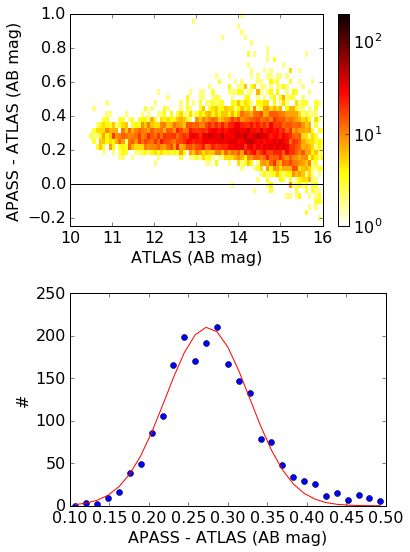

In [91]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,8))

plt.subplot(211)
b = [np.linspace(10,16,80),np.linspace(-.25,1,40)]
h = plt.hist2d(jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           jy2mag(cats[0].jy[indices_matching_srcs[0,indices_matching_srcs[0,:]>0]])-jy2mag(secat.jy[indices_matching_srcs[0,:]>0]),\
           bins=b,norm=matplotlib.colors.LogNorm(),cmap='hot_r',vmin=1,vmax=200)
plt.colorbar()
plt.plot([10,16],[0,0],'k-')
plt.xlabel('ATLAS (AB mag)')
plt.ylabel('APASS - ATLAS (AB mag)')

plt.subplot(212)
plt.plot(bins,counts,'o')
plt.plot(bins,gauss(bins,*coeff),'r-')
plt.xlabel('APASS - ATLAS (AB mag)')
plt.ylabel('#')

plt.tight_layout()

# plt.savefig('ATLAS_vs_APASS_cal.pdf',bbox_inches='tight')

In [92]:
coeff[0]

0.27422563466573774

In [93]:
.279/np.sqrt(np.sum(counts))

0.0061711166750931341

In [94]:
# 0.279 \pm 0.01

In [25]:
0.04

0.04